## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Global Variables

In [2]:
#This method initializes  global variables
def initGlobalVariables():
    global g_mtx #camera calibration matrix
    global g_dist #distortion coefficients
    global g_window_width #Window width for sliding window search
    global g_window_height #Window height for sliding window search
    global g_margin # How much to slide left and right for searching
    global g_minpix # Minimum pixel for sliding window search
    global g_src #Src points for perspective transform
    global g_dst #Destination points for perspective transform
    global g_nwindows # Choose the number of sliding windows

### Distortion Correction

In [3]:
# This function computes camera calibration matrix and distortion coefficients given a set of chessboard images.
def caliberate_camera(vis=False):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        fileName=fname.split("/")[1].split(".")[0]
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            if vis == True:
                # Draw and display the corners
                cv2.drawChessboardCorners(img, (9,6), corners, ret)
                f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
                ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
                ax1.set_title('Original Image', fontsize=18)
                ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                ax2.set_title('With Corners', fontsize=18)
                plt.savefig('output_images/chess_board_corners_'+fileName+".png")
                
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return (ret, mtx, dist, rvecs, tvecs)

#This function returns a undistorted image given distorted image, camera calibration matrix and distortion coefficients
def undistort(img,mtx,dist):
    udst_image = cv2.undistort(img, mtx, dist, None, mtx)
    return udst_image

## Get calibration matrix and distortion coefficients

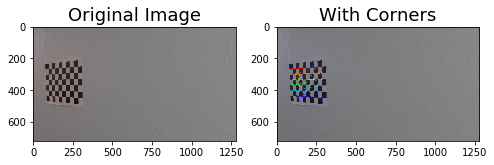

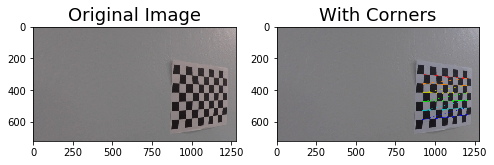

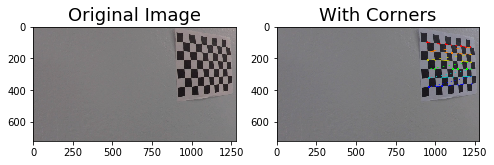

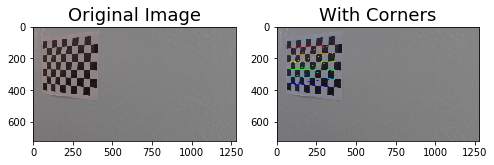

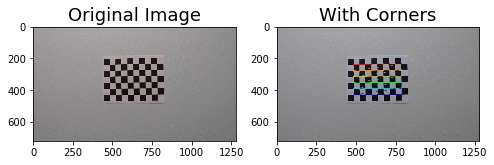

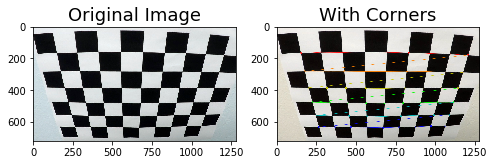

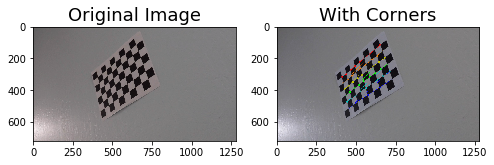

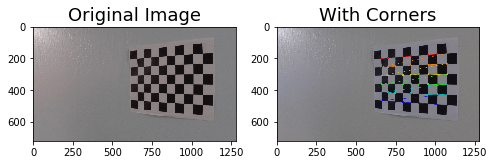

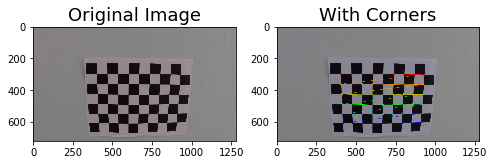

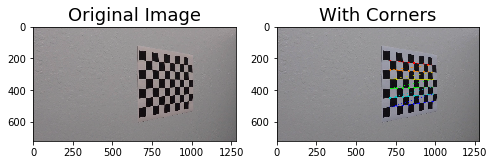

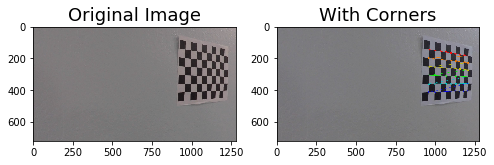

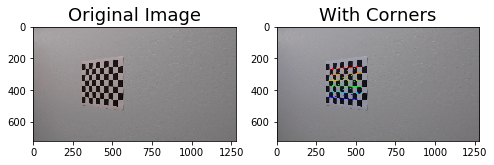

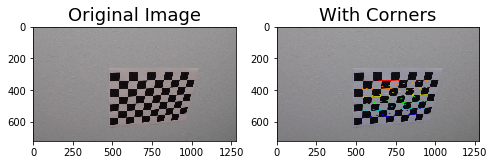

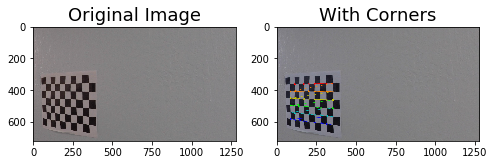

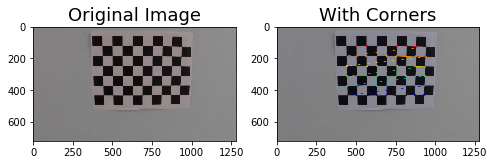

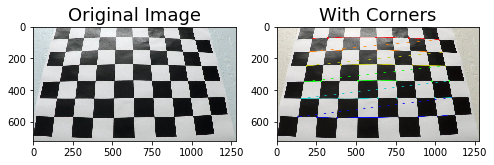

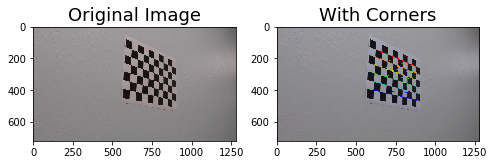

In [4]:
initGlobalVariables()
(ret, g_mtx, g_dist, rvecs, tvecs)=caliberate_camera(vis=True)

## Get undistorted test images

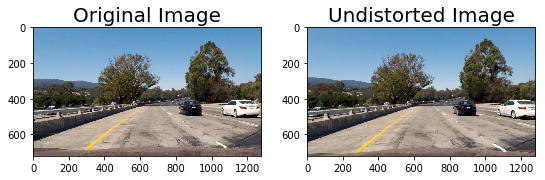

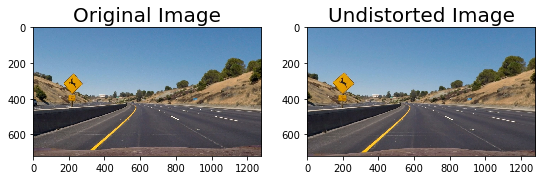

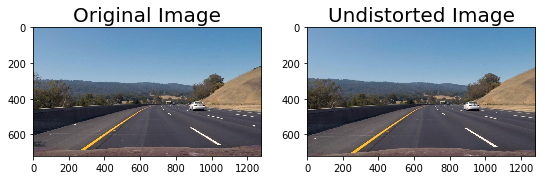

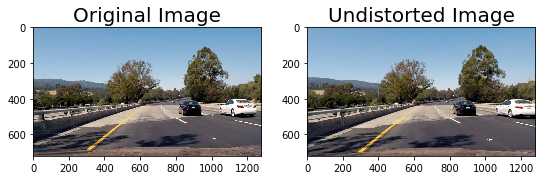

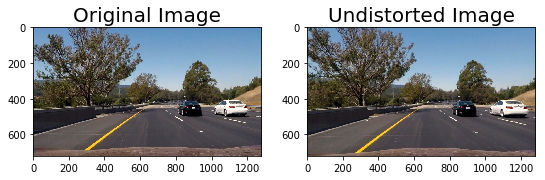

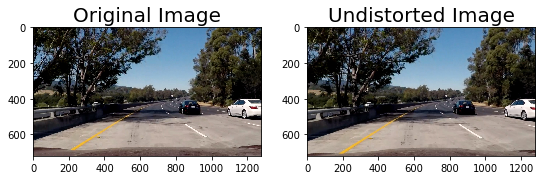

In [5]:
images = glob.glob('test_images/test*.jpg')
for fname in images:
    fileName=fname.split("/")[1].split(".")[0]
    img = cv2.imread(fname)
    undist = undistort(img,g_mtx, g_dist)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistorted Image', fontsize=20)
    plt.savefig('output_images/undistorted_'+fileName+".png")

## Perspective Transform

In [6]:
#This method performs perspective transform given an image source and destination points
def warper(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    return warped,M

## Perspective Transform on test images

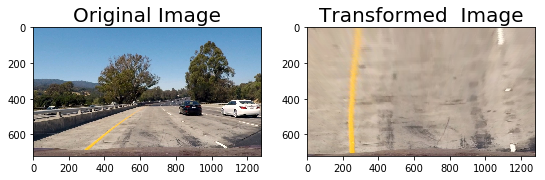

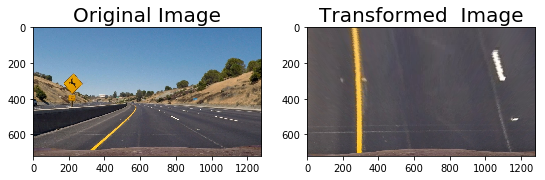

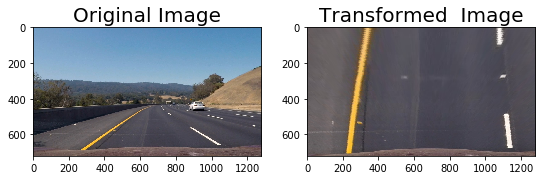

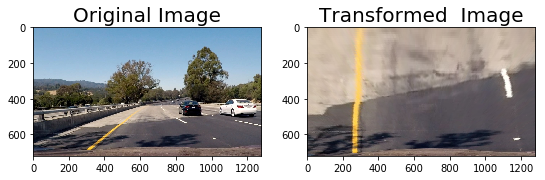

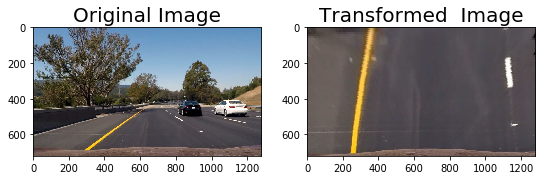

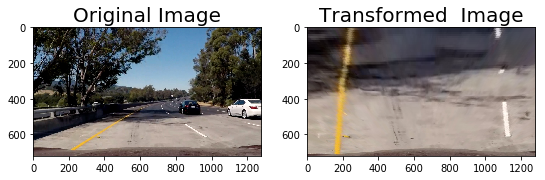

In [7]:
images = glob.glob('test_images/test*.jpg')
g_src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
g_dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])

for fname in images:
    fileName=fname.split("/")[1].split(".")[0]
    img = cv2.imread(fname)
    undist = undistort(img,g_mtx, g_dist)
    (binary_warped,M)=warper(undist,g_src,g_dst)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(cv2.cvtColor(binary_warped, cv2.COLOR_BGR2RGB))
    ax2.set_title('Transformed  Image', fontsize=20)
    plt.savefig('output_images/transformed_'+fileName+".png")
    

### Apply Binary Thresholds

In this section the following thresholds are applied to undistorted and wrapped and then are combined together
1. Abs Sobel Threshold in gray scale
2. Magnitude of Gradient Threshold
3. Direction of Gradient Threshold
4. Abs Sobel Threshold in HLS color scale
5. Combined Gradient

While experimenting with various threshold and sobel_kernel values I found the following threholds to work well.
* Sobel Kernel value 5
* Sobel Threshold of (20,100)
* Magnitude of Gradient Threshold of (25, 155)
* Direction of Gradient Threshold of (.6,1.2)

In [8]:
#This method retuns ABS Sobel Threshold
def abs_sobel_thresh(img, orient='x', ksize=5, thresh=(20, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=ksize))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=ksize))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

## ABS X and Y Sobel Threshold on Test images

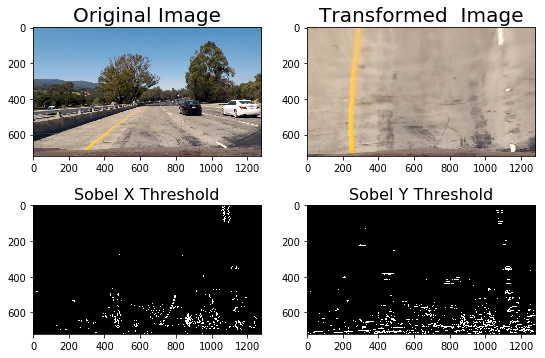

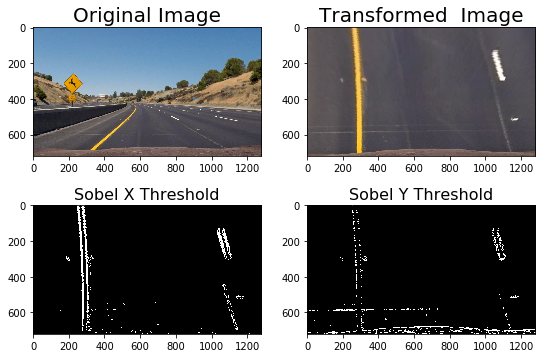

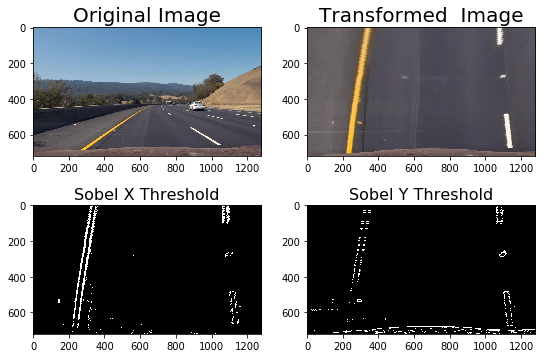

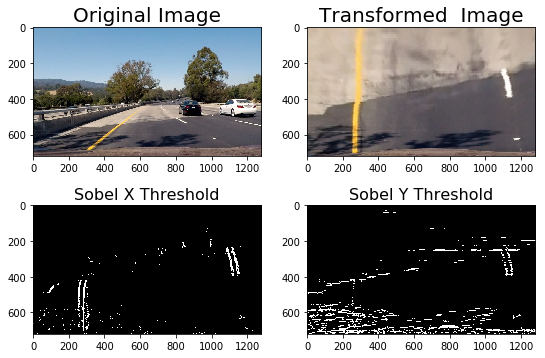

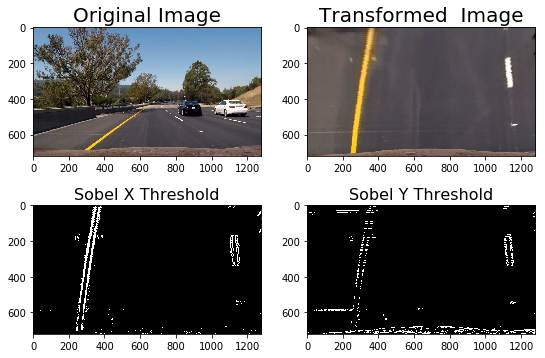

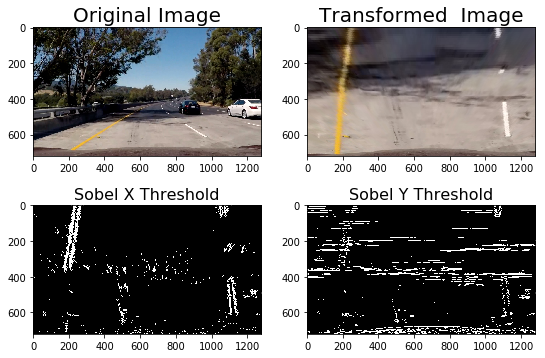

In [9]:
for fname in images:
    fileName=fname.split("/")[1].split(".")[0]
    img = cv2.imread(fname)
    undist = undistort(img,g_mtx, g_dist)
    (binary_warped,M)=warper(undist,g_src,g_dst)
    gradx = abs_sobel_thresh(binary_warped, orient='x')
    grady = abs_sobel_thresh(binary_warped, orient='y')
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,  figsize=(9,6))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(cv2.cvtColor(binary_warped, cv2.COLOR_BGR2RGB))
    ax2.set_title('Transformed  Image', fontsize=20)
    ax3.set_title('Sobel X Threshold', fontsize=16)
    ax3.imshow(gradx, cmap='gray')
    ax4.set_title('Sobel Y Threshold', fontsize=16)
    ax4.imshow(grady, cmap='gray')
    plt.savefig('output_images/SobelX_Y_Threshold_'+fileName+".png")

In [10]:
# This method retuns Magnitude of Gradient
def mag_thresh(img, ksize=5, mag_thresh=(25, 155)):
    # Convert to grayscal
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

## Magnitude of Gradinet Threshold on Test images

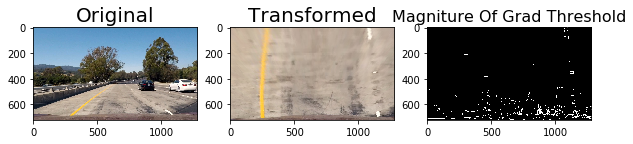

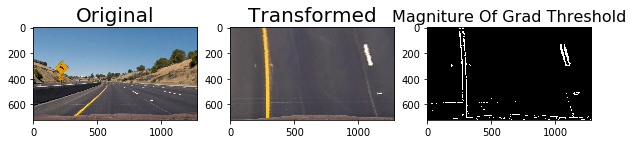

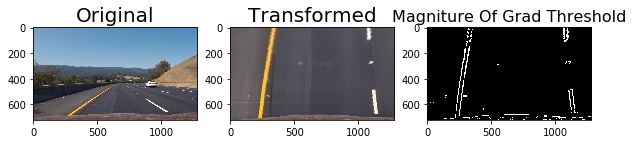

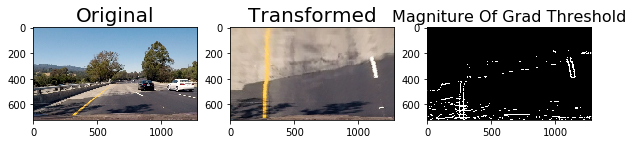

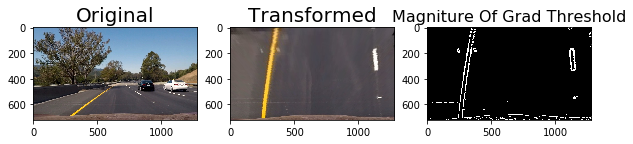

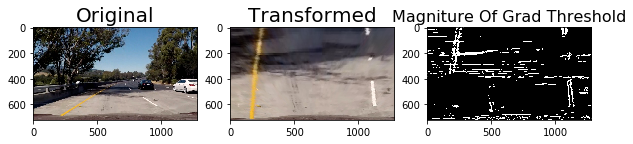

In [11]:
for fname in images:
    fileName=fname.split("/")[1].split(".")[0]
    img = cv2.imread(fname)
    undist = undistort(img,g_mtx, g_dist)
    (binary_warped,M)=warper(undist,g_src,g_dst)
    mag_grad = mag_thresh(binary_warped)
    f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,10))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original', fontsize=20)
    ax2.imshow(cv2.cvtColor(binary_warped, cv2.COLOR_BGR2RGB))
    ax2.set_title('Transformed', fontsize=20)
    ax3.set_title('Magniture Of Grad Threshold', fontsize=16)
    ax3.imshow(mag_grad, cmap='gray')
    plt.savefig('output_images/Mag_Grad_Threshold_'+fileName+".png")

In [12]:
# This method returns direction of gradient threshold
def dir_threshold(img, ksize=5, thresh=(.6,1.2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

## Direction of Gradinet Threshold on Test images

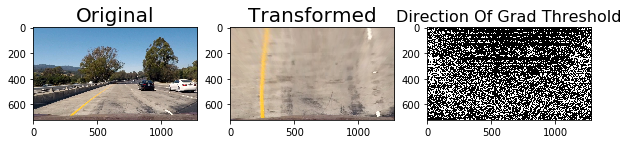

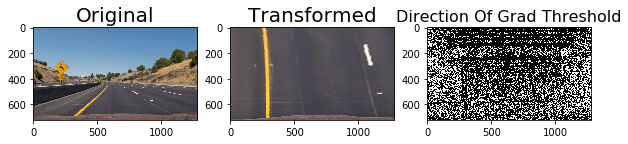

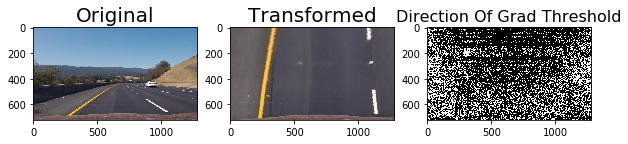

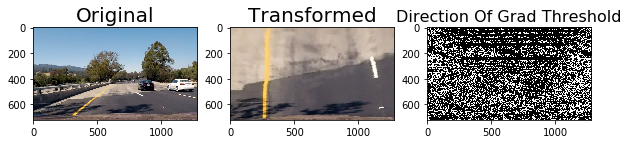

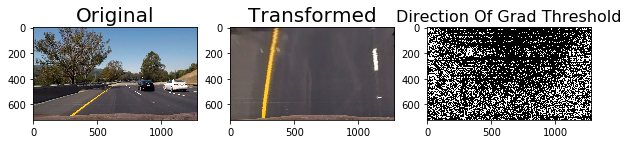

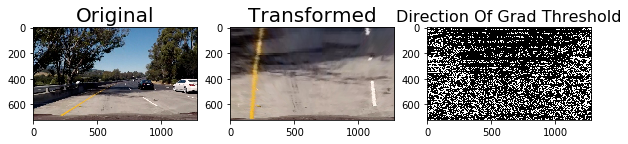

In [13]:
for fname in images:
    fileName=fname.split("/")[1].split(".")[0]
    img = cv2.imread(fname)
    undist = undistort(img,g_mtx, g_dist)
    (binary_warped,M)=warper(undist,g_src,g_dst)
    dir_grad = dir_threshold(binary_warped)
    f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,10))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original', fontsize=20)
    ax2.imshow(cv2.cvtColor(binary_warped, cv2.COLOR_BGR2RGB))
    ax2.set_title('Transformed', fontsize=20)
    ax3.set_title('Direction Of Grad Threshold', fontsize=16)
    ax3.imshow(dir_grad, cmap='gray')
    plt.savefig('output_images/Dir_Grad_Threshold_'+fileName+".png")

In [14]:
#This method reurns gradient of HLS l channel 
def hls_select_l(img, ksize=5, sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
   
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=ksize) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    return sxbinary

#This method reurns gradient of HLS l channel 
def hls_select_s(img,ksize=5, sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=ksize) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    return sxbinary

## HLS Gradinet Threshold on Test images

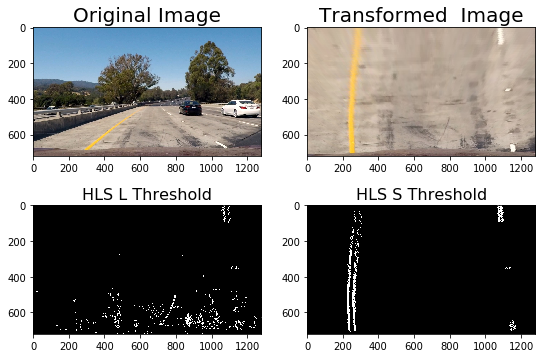

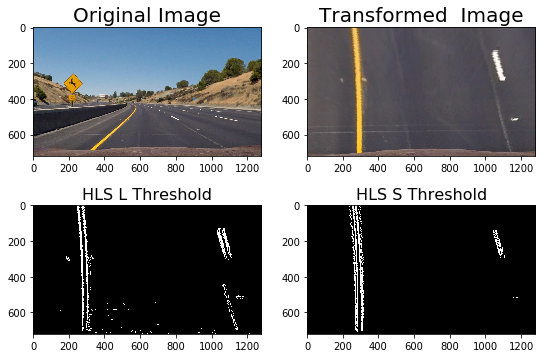

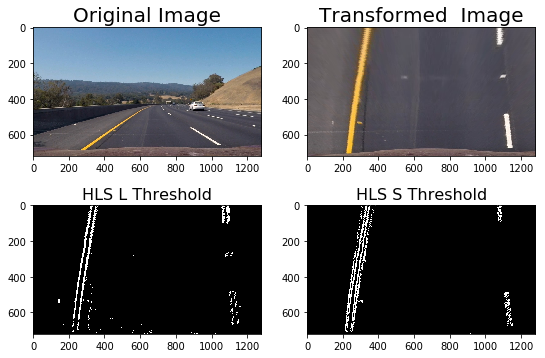

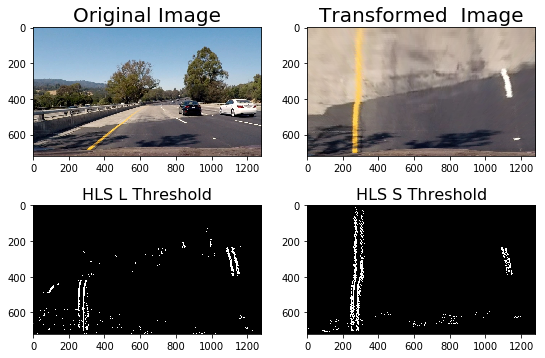

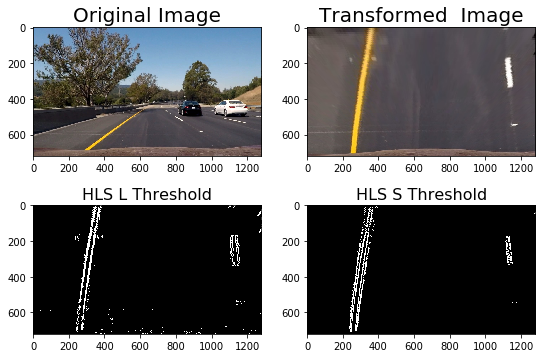

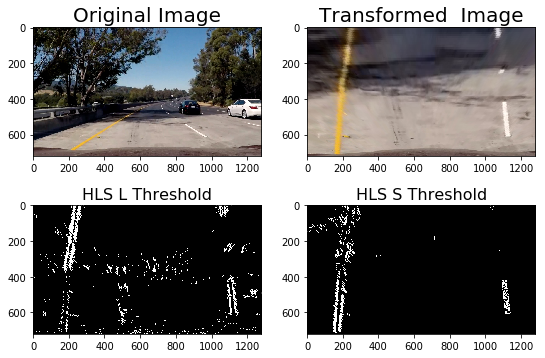

In [15]:
for fname in images:
    fileName=fname.split("/")[1].split(".")[0]
    img = cv2.imread(fname)
    undist = undistort(img,g_mtx, g_dist)
    (binary_warped,M)=warper(undist,g_src,g_dst)
    hls_l = hls_select_l(binary_warped)
    hls_s = hls_select_s(binary_warped)
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,  figsize=(9,6))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(cv2.cvtColor(binary_warped, cv2.COLOR_BGR2RGB))
    ax2.set_title('Transformed  Image', fontsize=20)
    ax3.set_title('HLS L Threshold', fontsize=16)
    ax3.imshow(hls_l, cmap='gray')
    ax4.set_title('HLS S Threshold', fontsize=16)
    ax4.imshow(hls_s, cmap='gray')
    plt.savefig('output_images/HLS_L_S_Threshold_'+fileName+".png")

In [16]:
#This method combines all the gradients together
def combined_gradient(img,ksize=5, thresh=(20, 100),dir_thresh=(.6,1.2),m_thresh=(25, 155)):
    s_binary_l=hls_select_l(img,ksize=ksize, sx_thresh=thresh)
    s_binary_s=hls_select_s(img,ksize=ksize, sx_thresh=thresh)
    gradx = abs_sobel_thresh(img, orient='x', ksize=ksize, thresh=thresh)
    grady = abs_sobel_thresh(img, orient='y', ksize=ksize, thresh=thresh)
    mag_binary = mag_thresh(img,ksize=ksize,mag_thresh=m_thresh)
    dir_binary = dir_threshold(img,ksize=ksize,thresh=dir_thresh)

#   Combine thresholds
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[(s_binary_s == 1)|(s_binary_l == 1) | (gradx == 1) | (grady == 1) | (mag_binary == 1) | (dir_binary == 1)] = 1
    return combined_binary

## Combined Gradinet Threshold on Test images

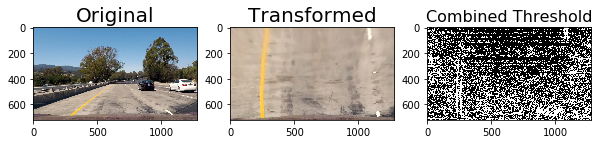

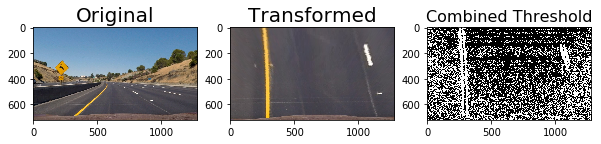

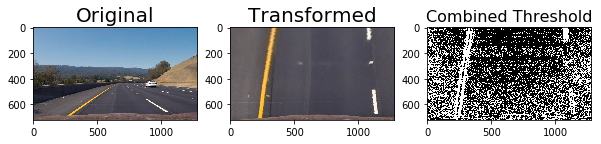

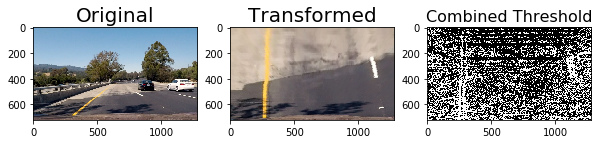

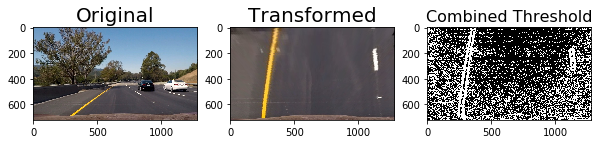

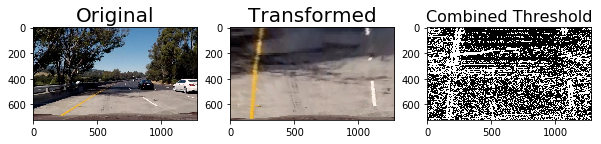

In [17]:
for fname in images:
    fileName=fname.split("/")[1].split(".")[0]
    img = cv2.imread(fname)
    undist = undistort(img,g_mtx, g_dist)
    (binary_warped,M)=warper(undist,g_src,g_dst)
    combined = combined_gradient(binary_warped)
    f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,10))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original', fontsize=20)
    ax2.imshow(cv2.cvtColor(binary_warped, cv2.COLOR_BGR2RGB))
    ax2.set_title('Transformed', fontsize=20)
    ax3.set_title('Combined Threshold', fontsize=16)
    ax3.imshow(combined, cmap='gray')
    plt.savefig('output_images/Combined_Threshold_'+fileName+".png")

## Finding lane line

On the thresholded warped image a histogram is taken along all the columns in the lower half of the image.
On this a sliding window search is run to identify pixels that are associated with the lane lines.A second order polynomial is fit to each of the identified lane pixels.

In [18]:
#Initialize variables
g_window_width = 10 
g_window_height = 10 
g_margin = 100 
g_minpix = 50
g_nwindows = 10

In [19]:
#This method is used to detects lane lines
def get_laneLines(img):
    un_distorted=undistort(img,g_mtx,g_dist)
    threshold_img=combined_gradient(un_distorted)
    (binary_warped,M)=warper(threshold_img,g_src,g_dst)
    shape=int(binary_warped.shape[0])
    indx=int(shape/2)
    
    histogram = np.sum(binary_warped[indx:shape,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/g_nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    #Sliding window search
    # Step through the windows one by one
    for window in range(g_nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - g_margin
        win_xleft_high = leftx_current + g_margin
        win_xright_low = rightx_current - g_margin
        win_xright_high = rightx_current + g_margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > g_minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > g_minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return (out_img,left_fitx,right_fitx,ploty)


## Find lane lines on test images

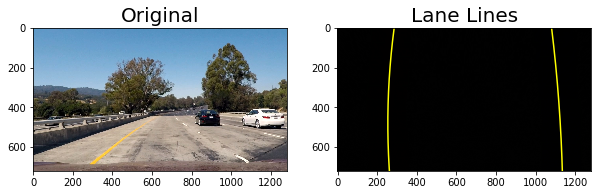

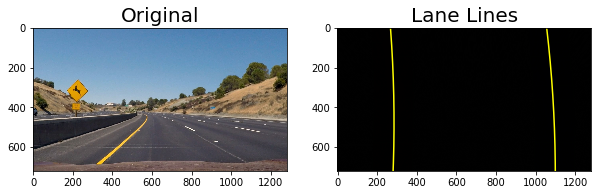

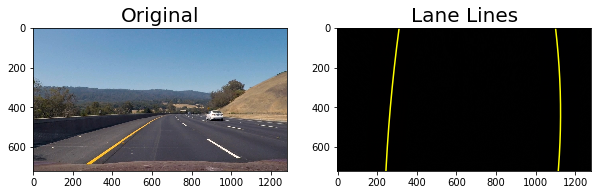

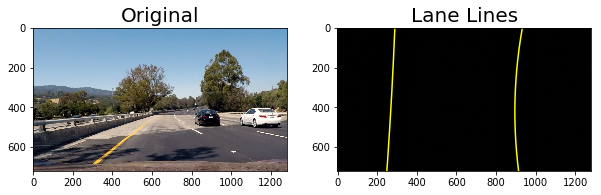

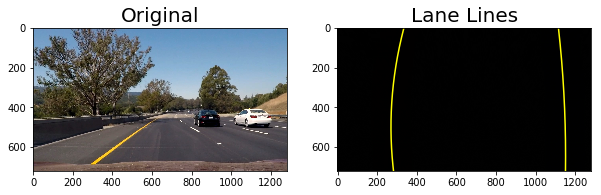

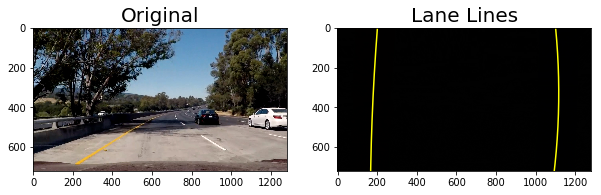

In [21]:
for fname in images:
    fileName=fname.split("/")[1].split(".")[0]
    img = cv2.imread(fname)
    (out_img,left_fitx,right_fitx,ploty) = get_laneLines(img)
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original', fontsize=20)
    ax2.imshow(out_img)
    ax2.plot(left_fitx, ploty, color='yellow')
    ax2.plot(right_fitx, ploty, color='yellow')
    ax2.set_title('Lane Lines', fontsize=20)
    plt.savefig('output_images/Lane_Lines_'+fileName+".png")

## Radius of Curvature
The radius of curvature  at any point x of the function x=f(y) is given at this page: http://www.intmath.com/applications-differentiation/8-radius-curvature.php:

## Fill lane lines

In [22]:
#This method is used to detect and fill lane lines
def fill_laneLines(img):
    un_distorted=undistort(img,g_mtx,g_dist)
    threshold_img=combined_gradient(un_distorted)
    (binary_warped,M)=warper(threshold_img,g_src,g_dst)
    shape=int(binary_warped.shape[0])
    indx=int(shape/2)
    
    histogram = np.sum(binary_warped[indx:shape,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/g_nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    #Sliding window search
    # Step through the windows one by one
    for window in range(g_nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - g_margin
        win_xleft_high = leftx_current + g_margin
        win_xright_low = rightx_current - g_margin
        win_xright_high = rightx_current + g_margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > g_minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > g_minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Calculate right and left intercepts 
    rightx_int, right_top = get_intercepts(right_fit)
    leftx_int, left_top = get_intercepts(left_fit)
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-g_margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+g_margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-g_margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+g_margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Calculate the vehicle position relative to the center of the lane
    position = (rightx_int+leftx_int)/2
    distance_from_center = abs((640 - position)*3.7/700) 
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv=np.linalg.pinv(M)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
 
    
    # Print distance from center on video
    if position > 640:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 3)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 3)
    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((left_curverad+right_curverad)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 3)
    
    
    return (result)

    
def get_intercepts(polynomial):
    bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
    top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
    return bottom, top

## Fill lane lines on test images

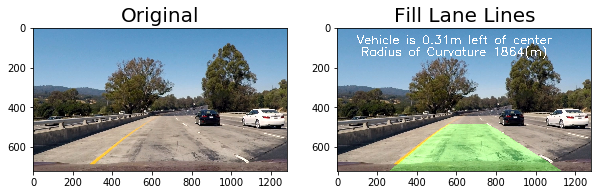

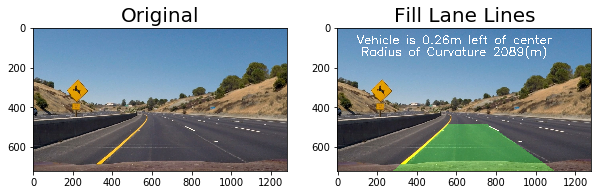

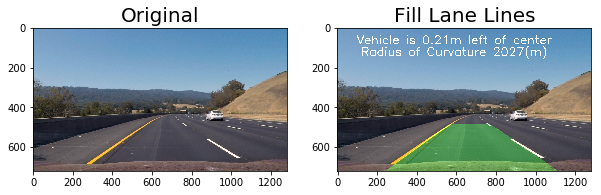

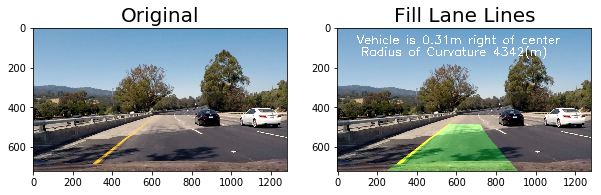

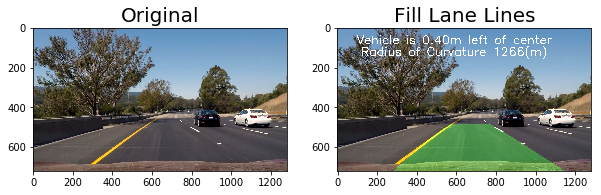

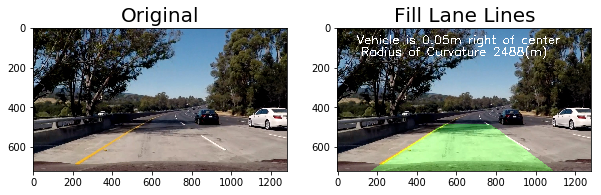

In [23]:
for fname in images:
    fileName=fname.split("/")[1].split(".")[0]
    img = cv2.imread(fname)
    out_img = fill_laneLines(img)
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original', fontsize=20)
    ax2.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
    ax2.set_title('Fill Lane Lines', fontsize=20)
    plt.savefig('output_images/Fill_Lane_Lines_'+fileName+".png")

## Video Pipeline

While calculating lanes in video pipleline sliding windows step runs only for the first frame. Once lines are known In the next frame of video we can just search in a margin around the previous line position . To do this best fit from the previous frame is stored for use in the next frame. 

In [24]:
#Line class to store previous best fit
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [25]:
#This method processes image and detects lane lines , vehicle position and curvature of the road
def process_image_pipeline(img):
    un_distorted=undistort(img,g_mtx,g_dist)
    threshold_img=combined_gradient(un_distorted)
    (binary_warped,M)=warper(threshold_img,g_src,g_dst)
    shape=int(binary_warped.shape[0])
    indx=int(shape/2)
    
    histogram = np.sum(binary_warped[indx:shape,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/g_nwindows)
    
    #If this is the first frame
    if (Rightline.best_fit == None) or (Leftline.best_fit == None):
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        #Sliding window search
        # Step through the windows one by one
        for window in range(g_nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - g_margin
            win_xleft_high = leftx_current + g_margin
            win_xright_low = rightx_current - g_margin
            win_xright_high = rightx_current + g_margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > g_minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > g_minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    #Use the previous fit
    else:
        right_fit=Rightline.best_fit
        left_fit=Leftline.best_fit
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])


        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - g_margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + g_margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - g_margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + g_margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    Rightline.best_fit=right_fit
    Leftline.best_fit=left_fit   
    # Calculate right and left intercepts 
    rightx_int, right_top = get_intercepts(right_fit)
    leftx_int, left_top = get_intercepts(left_fit)
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-g_margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+g_margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-g_margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+g_margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Calculate the vehicle position relative to the center of the lane
    position = (rightx_int+leftx_int)/2
    distance_from_center = abs((640 - position)*3.7/700) 
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv=np.linalg.pinv(M)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
        # Print distance from center on video
    if position > 640:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 3)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 3)
    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((left_curverad+right_curverad)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 3)
    

    return result

In [26]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [27]:
Leftline = Line() #Left Lane
Rightline = Line() #Right Lane
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image_pipeline) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [06:35<00:00,  3.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [28]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('project_video_output.mp4'))

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.
Faced issues while choosing appropriate parameters for Thresholds and sliding window search. Also the pipeline runs very slow for a self driving car the pipeline need to be very fast.

#### 2. Where will your pipeline likely fail?
The pipeline at times slightly oscillates while detecting lanes . This can cause the vehicle to take unnecessary  action.

#### 3. What could you do to make it more robust?

By using moving average of k previous frame lane lines rather than just previous frame can help in preventing this oscillation.

Also pipeline speed need to be improved to be used in a self driving car.